## by Jan Willem de Gee (jwdegee@gmail.com)

In [40]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt

import seaborn as sns
import hddm
from joblib import Parallel, delayed
from IPython import embed as shell

Let's start with defining some functionality

In [41]:
def get_choice(row):
    
    if row.condition == 'present':
        if row.response == 1:
            return 1
        else:
            return 0
    elif row.condition == 'absent':
        if row.response == 0:
            return 1
        else:
            return 0

def simulate_data(a, v, t, z, dc, sv=0, sz=0, st=0, condition=0, nr_trials1=1000, nr_trials2=1000):
    
    """
    Simulates stim-coded data.
    """
    
    parameters1 = {'a':a, 'v':v+dc, 't':t, 'z':z, 'sv':sv, 'sz': sz, 'st': st}
    parameters2 = {'a':a, 'v':v-dc, 't':t, 'z':1-z, 'sv':sv, 'sz': sz, 'st': st}
    df_sim1, params_sim1 = hddm.generate.gen_rand_data(params=parameters1, size=nr_trials1, subjs=1, subj_noise=0)
    df_sim1['condition'] = 'present'
    df_sim2, params_sim2 = hddm.generate.gen_rand_data(params=parameters2, size=nr_trials2, subjs=1, subj_noise=0)
    df_sim2['condition'] = 'absent'
    df_sim = pd.concat((df_sim1, df_sim2))
    df_sim['bias_response'] = df_sim.apply(get_choice, 1)
    df_sim['correct'] = df_sim['response'].astype(int)
    df_sim['response'] = df_sim['bias_response'].astype(int)
    df_sim['stimulus'] = np.array((np.array(df_sim['response']==1) & np.array(df_sim['correct']==1)) + (np.array(df_sim['response']==0) & np.array(df_sim['correct']==0)), dtype=int)
    df_sim['condition'] = condition
    df_sim = df_sim.drop(columns=['bias_response'])
    
    return df_sim

def conditional_response_plot(df, quantiles, xlim=None):
    
    fig = plt.figure(figsize=(2,2))
    ax = fig.add_subplot(1,1,1)
    df.loc[:,'rt_bin'] = pd.qcut(df['rt'], quantiles, labels=False)
    d = df.groupby(['subj_idx', 'rt_bin']).mean().reset_index()
    for s, c in zip(np.unique(d["subj_idx"]), ['lightgrey', 'grey', 'black']):
        ax.errorbar(d.loc[d["subj_idx"]==s, "rt"], d.loc[d["subj_idx"]==s, "response"], fmt='-o', color=c, markersize=5)
    plt.axhline(0.5)
    if xlim:
        ax.set_xlim(xlim)
    ax.set_ylim(0.2,1)
    ax.set_title('P(correct) = {}\nP(bias) = {}'.format(
                                                    round(df['correct'].mean(), 2),
                                                    round(df['response'].mean(), 2),
                                                    ))
    ax.set_xlabel('RT (s)')
    ax.set_ylabel('P(bias)')
    sns.despine(offset=10, trim=True)
    plt.tight_layout()
    
    return fig

Let's simulate our own data, so we know what the fitting procedure should converge on:

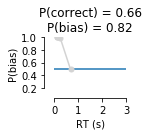

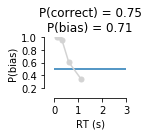

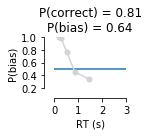

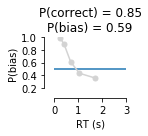

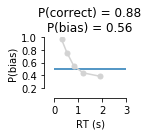

In [42]:
# settings
trials_per_level = 50000

z = 1.8
absolute_z = True

# parameters:
if absolute_z:
    params0 = {'cond':0, 'v':1, 'a':2.0, 't':0.1, 'z':z/2.0, 'dc':0, 'sz':0, 'st':0, 'sv':0.5}
    params1 = {'cond':1, 'v':1, 'a':2.2, 't':0.1, 'z':z/2.2, 'dc':0, 'sz':0, 'st':0, 'sv':0.5}
    params2 = {'cond':2, 'v':1, 'a':2.4, 't':0.1, 'z':z/2.4, 'dc':0, 'sz':0, 'st':0, 'sv':0.5}
    params3 = {'cond':3, 'v':1, 'a':2.6, 't':0.1, 'z':z/2.6, 'dc':0, 'sz':0, 'st':0, 'sv':0.5}
    params4 = {'cond':4, 'v':1, 'a':2.8, 't':0.1, 'z':z/2.8, 'dc':0, 'sz':0, 'st':0, 'sv':0.5}
else:
    params0 = {'cond':0, 'v':1, 'a':1.0, 't':0.1, 'z':z, 'dc':0, 'sz':0, 'st':0, 'sv':0.5}
    params1 = {'cond':1, 'v':1, 'a':1.5, 't':0.1, 'z':z, 'dc':0, 'sz':0, 'st':0, 'sv':0.5}
    params2 = {'cond':2, 'v':1, 'a':2.0, 't':0.1, 'z':z, 'dc':0, 'sz':0, 'st':0, 'sv':0.5}
    params3 = {'cond':3, 'v':1, 'a':2.5, 't':0.1, 'z':z, 'dc':0, 'sz':0, 'st':0, 'sv':0.5}
    params4 = {'cond':4, 'v':1, 'a':3.0, 't':0.1, 'z':z, 'dc':0, 'sz':0, 'st':0, 'sv':0.5}
    
# simulate:
dfs = []
for i, params in enumerate([params0, params1, params2, params3, params4]):
    df = simulate_data(z=params['z'], a=params['a'], v=params['v'], dc=params['dc'], 
                        t=params['t'], sv=params['sv'], st=params['st'], sz=params['sz'], 
                        condition=params['cond'], nr_trials1=trials_per_level, nr_trials2=trials_per_level)
    df['subj_idx'] = 0
    
    fig = conditional_response_plot(df, quantiles=[0, 0.1, 0.3, 0.5, 0.7, 0.9,], xlim=(0,3))
    fig.savefig('crf{}.pdf'.format(i))
    
    dfs.append(df)

# combine in one dataframe:
df_emp = pd.concat(dfs)

Fit using the g-quare method.

In [43]:
# fit chi-square:
quantiles = [.1, .3, .5, .7, .9]

m = hddm.HDDMStimCoding(df_emp, stim_col='stimulus', split_param='v', drift_criterion=True, bias=True,
                        include=('sv'), depends_on={'a':'condition', 'z':'condition', 'dc':'condition', }, p_outlier=0,)
m.optimize('gsquare', quantiles=quantiles, n_runs=5)
params_fitted = pd.concat((pd.DataFrame([m.values], index=[0]), pd.DataFrame([m.bic_info], index=[0])), axis=1)

/anaconda3/envs/hddm/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 2131691.212622
         Iterations: 9
         Function evaluations: 1900
Optimization terminated successfully.
         Current function value: 2131702.124079
         Iterations: 8
         Function evaluations: 1681
Optimization terminated successfully.
         Current function value: 2131608.500906
         Iterations: 8
         Function evaluations: 1673
Optimization terminated successfully.
         Current function value: 2132139.601586
         Iterations: 9
         Function evaluations: 2002
Optimization terminated successfully.
         Current function value: 2132514.404682
         Iterations: 8
         Function evaluations: 1849


In [44]:
params_fitted.drop(['bic', 'likelihood', 'penalty', 'z_trans(0)', 'z_trans(1)', 'z_trans(2)', 'z_trans(3)', 'z_trans(4)'], axis=1, inplace=True)
print(params_fitted.head())

       a(0)     a(1)      a(2)      a(3)      a(4)         v         t  \
0  1.989507  2.19733  2.395642  2.580556  2.773528  0.998067  0.099715   

         sv      z(0)     z(1)      z(2)      z(3)      z(4)     dc(0)  \
0  0.484886  0.898134  0.81771  0.748756  0.687783  0.639324  0.014617   

      dc(1)    dc(2)     dc(3)     dc(4)  
0 -0.001682  0.00827  0.013622  0.010536  


18


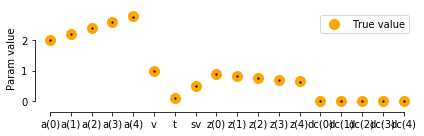

In [45]:
# plot true vs recovered parameters:
x = np.arange(18)
y0 = np.array([params0['a'], params1['a'], params2['a'], params3['a'], params4['a'], params0['v'], params0['t'], params0['sv'], params0['z'], params1['z'], params2['z'],params3 ['z'],params4['z'], params0['dc'], params1['dc'], params2['dc'], params3['dc'], params4['dc']])

print(len(y0))

# y1 = np.array([params1['a'], params1['v'], params1['t'], params1['z'], params1['dc']])
fig = plt.figure(figsize=(6,2))
ax = fig.add_subplot(111)
ax.scatter(x, y0, marker="o", s=100, color='orange', label='True value')
# ax.scatter(x+1, y1, marker="o", s=100, color='orange',)
sns.stripplot(data=params_fitted, jitter=False, size=2, edgecolor='black', linewidth=0.25, alpha=1, palette=['black', 'black'], ax=ax)
plt.ylabel('Param value')
plt.legend()
sns.despine(offset=5, trim=True,)
plt.tight_layout()
fig.savefig('param_recovery.pdf')

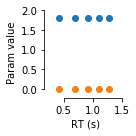

In [46]:
fig = plt.figure(figsize=(2,2))
absolute_z = True
if absolute_z:
    plt.scatter(df_emp.groupby('condition').mean()['rt'], [params0['z']*params0['a'], params1['z']*params1['a'], params2['z']*params2['a'], params3['z']*params3['a'], params4['z']*params4['a']])
    plt.scatter(df_emp.groupby('condition').mean()['rt'], [params0['dc'], params1['dc'], params2['dc'],params3 ['dc'],params4['dc']])
else:
    plt.scatter(df_emp.groupby('condition').mean()['rt'], [params0['z'], params1['z'], params2['z'],params3 ['z'],params4['z']])
    plt.scatter(df_emp.groupby('condition').mean()['rt'], [params0['dc'], params1['dc'], params2['dc'],params3 ['dc'],params4['dc']])
plt.ylabel('Param value')
plt.xlabel('RT (s)')
plt.xlim(0.25,1.5)
plt.ylim(-0.1,2.0)
sns.despine(offset=5, trim=True,)
plt.tight_layout()
fig.savefig('param_recovery2.pdf')